/tmp/ipykernel_133814/2146980924.py:112: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(positions[:10], [0.645,0.645,0.421,0.405,0.295,0.42,0.405,0.52,0.55, 0.79],
/tmp/ipykernel_133814/2146980924.py:114: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(positions[:10], [0.95,0.81,0.69,0.72,0.70,0.718,0.721,0.84,0.835, 0.9],
/tmp/ipykernel_133814/2146980924.py:157: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(positions[:10], [0.59,0.03,0.016,0.00,0.01,0.02,0.038,0.038,0.052, 0.21],
/tmp/ipykernel_133814/2146980924.py:159: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string 

Wilcoxon one-sided tests for Mean Recall Prob. (With Attention > Without Attention):
  Hidden Dim 32: W=91.00, n=13, p=1.22e-04, r_rb=1.000
  Hidden Dim 64: W=91.00, n=13, p=1.22e-04, r_rb=1.000
  Hidden Dim 128: W=29.00, n=13, p=8.78e-01, r_rb=-0.363


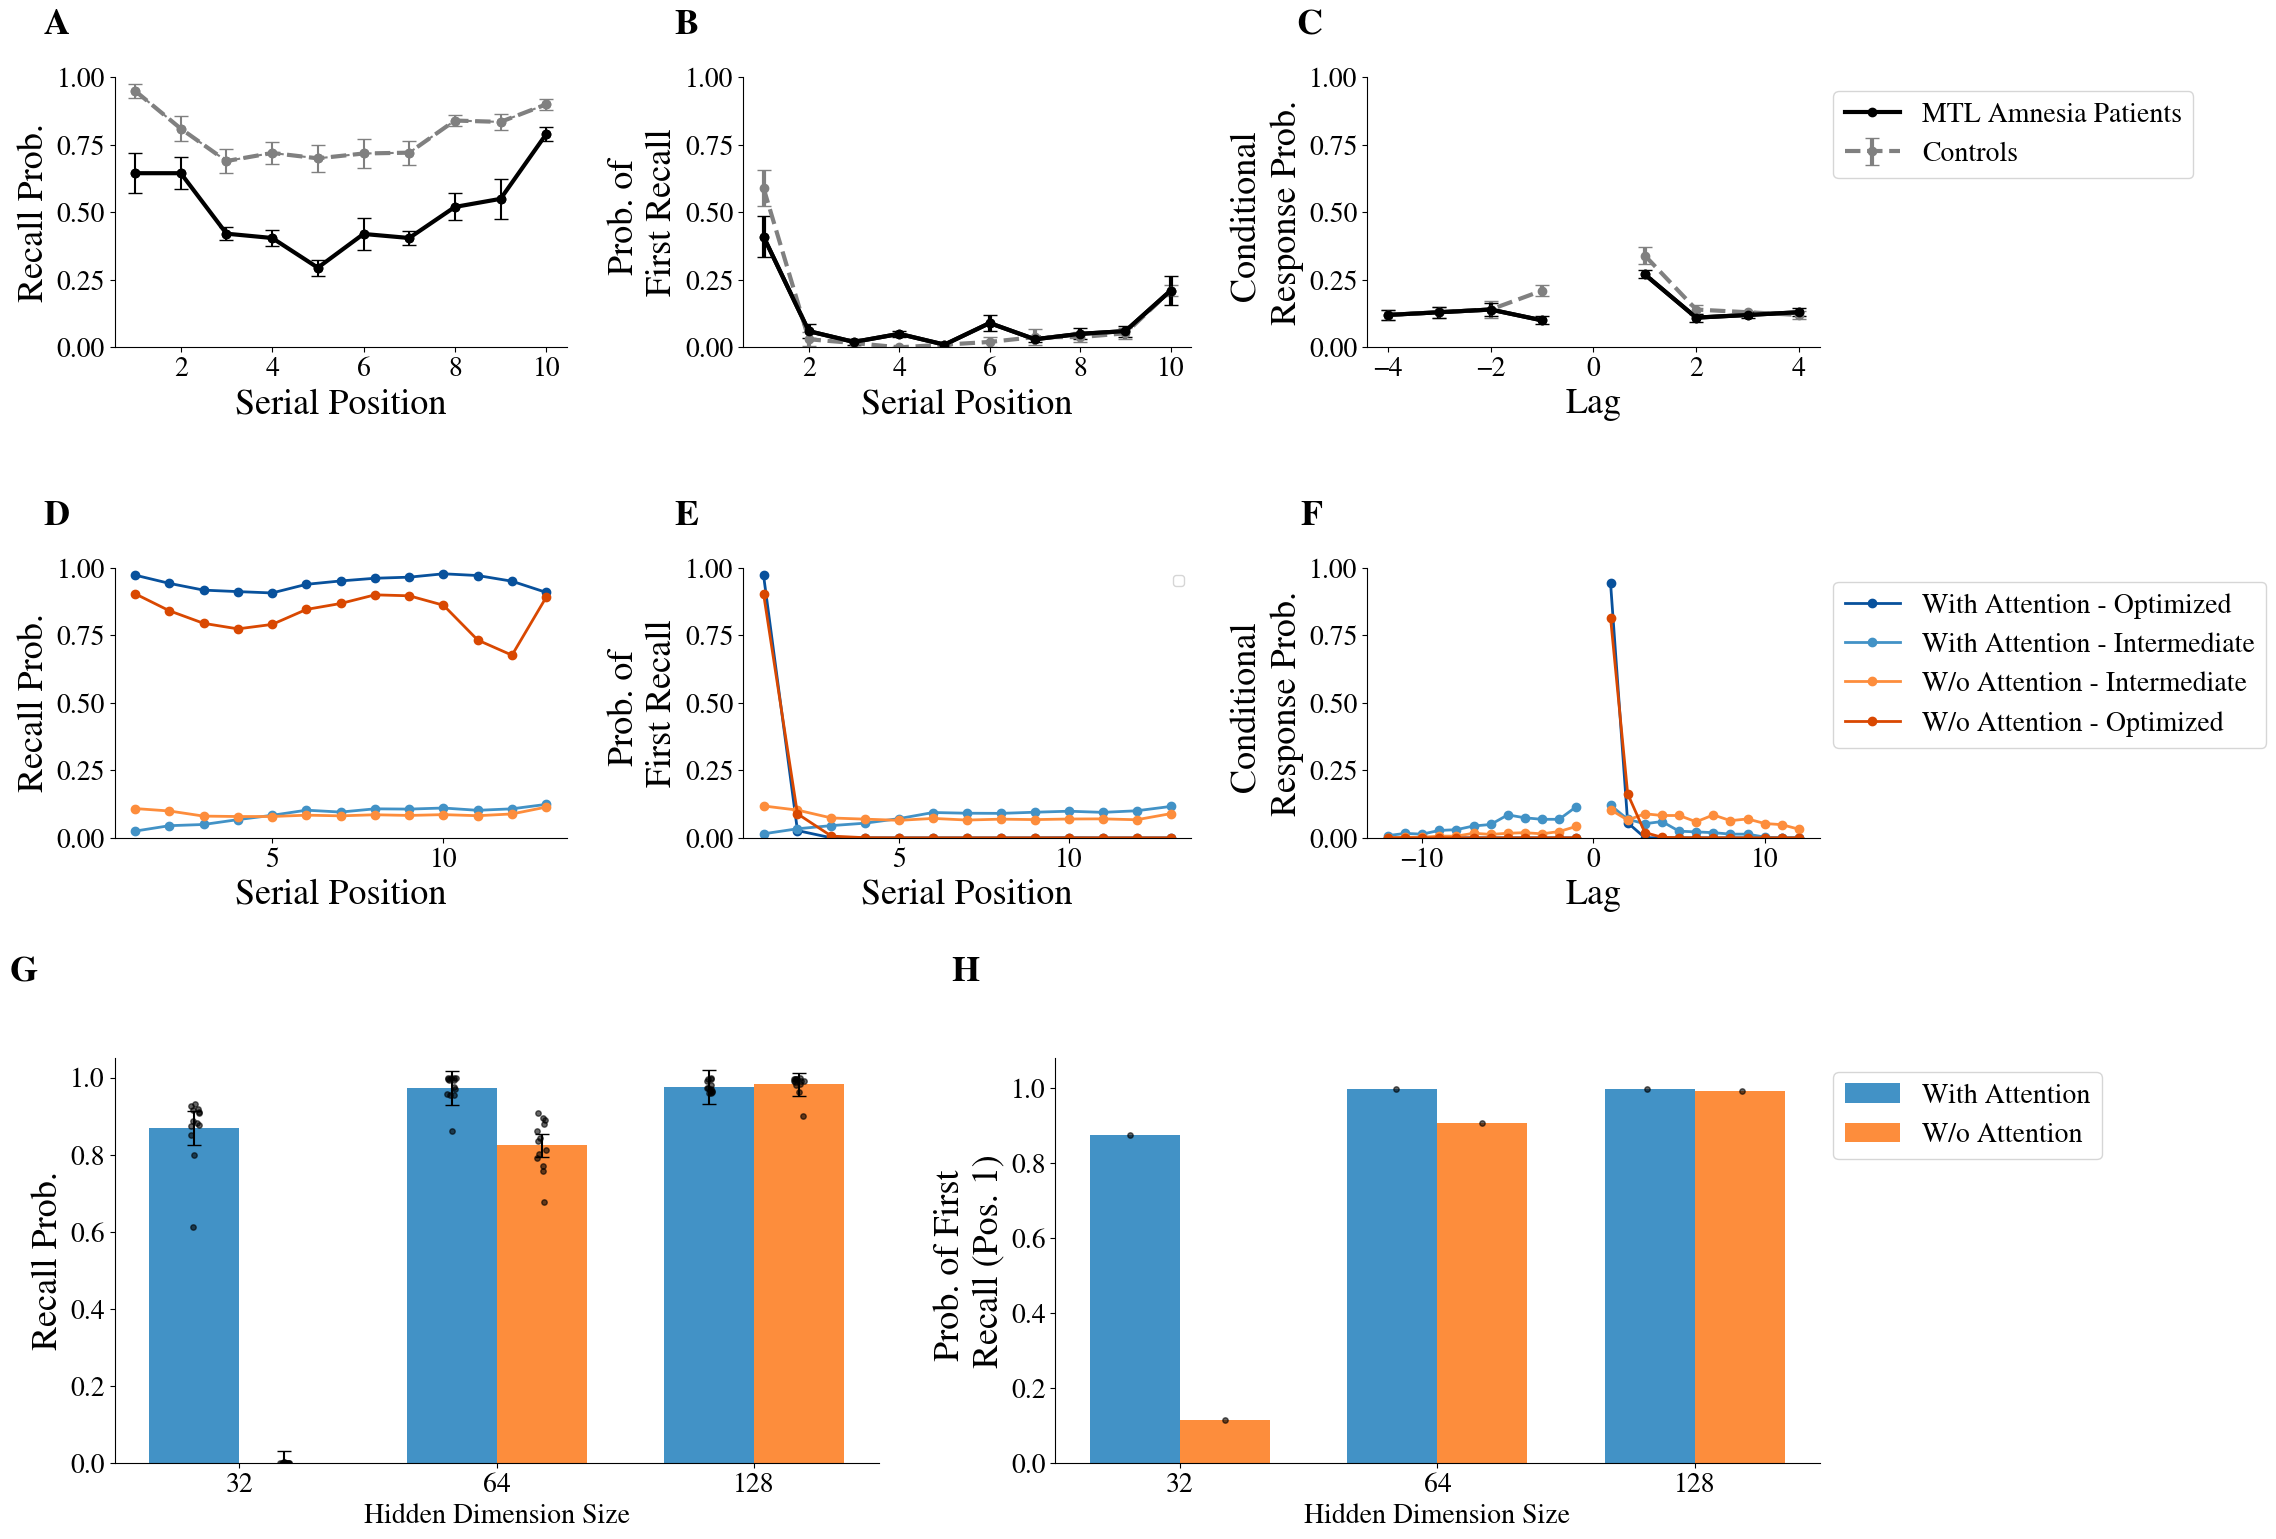

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import seaborn as sns
import random
import os
import re
from scipy.stats import wilcoxon, rankdata
from pathlib import Path
import ipynbname

nb_path = Path(ipynbname.path())
data_path = nb_path.parent.parent

def rank_biserial_from_pairs(x, y):
    d = np.asarray(x) - np.asarray(y)
    d = d[d != 0]
    if d.size == 0:
        return np.nan
    rks = rankdata(np.abs(d), method='average')
    return (rks[d > 0].sum() - rks[d < 0].sum()) / rks.sum()

mpl.rcParams.update({'errorbar.capsize': 5})

from nmt_cmr_parallels.utils.evaluation_utils import (calculate_conditional_recall_probability, 
                                                  calculate_recall_probability,
                                                  calculate_first_recall_probability)

def extract_number(label):
    match = re.search(r'Epoch-(\d+)', label)
    return int(match.group(1)) if match else float('inf')

def extract_sort_keys(file_path):
    attention_type_match = re.search(r'/(Attention|NoAttention)-', file_path)
    dimension_match = re.search(r'-(\d+)Dim', file_path)

    attention_type = attention_type_match.group(1) if attention_type_match else ''
    dimension_number = int(dimension_match.group(1)) if dimension_match else 0

    return attention_type, dimension_number

def extract_dimension(filename):
    match = re.search(r'(\d+)Dim\.json$', filename)
    return int(match.group(1)) if match else 0

no_attention_dir = data_path / "resource" / "evaluations" / "no_attention"
attention_dir = data_path / "resource" / "evaluations" / "attention"
hidden_dim_dir = data_path / "resource" / "evaluations" / "varying_hidden_dim"

no_attention_files = [os.path.join(no_attention_dir, x) for x in os.listdir(str(no_attention_dir)) if x.endswith('.json')]
attention_files = [os.path.join(attention_dir, x) for x in os.listdir(str(attention_dir)) if x.endswith('.json') and 'Human' not in x]
hidden_dim_files = [os.path.join(hidden_dim_dir, x) for x in os.listdir(str(hidden_dim_dir)) if x.endswith('.json')]

bigfont = 26
smallfont = 20

# Create figure
fig = plt.figure(figsize=(22, 18))
plt.rcParams['font.family'] = 'Nimbus Roman'
gs = GridSpec(nrows=3, ncols=4, figure=fig, width_ratios=[1,0.3,0.3,1], height_ratios=[1,1,1.5])

################################################
# Amnesia Plots

end_position = 11
omit_first_k = 1
curr_fig_label = "NoAttention-128Dim-Epoch-20"

filepath = data_path / "resource" / "evaluations" / "attention" / "Epoch-9.json"

ax = fig.add_subplot(gs[0, 0])

ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_ylim((0.0,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
#plt.title('Recall Prob. for NMT Model and Optimal CMR', fontsize=23)
#ax.set_title('Recall Prob. for Amnesiac and Control Patients', fontsize=23)
with open(filepath,'r') as f:
    data = json.load(f)

if omit_first_k is not None:
    data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
    data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

recall_probabilities = calculate_recall_probability(data['original_sequences'], data['predicted_sequences'])
label = os.path.splitext(os.path.basename(filepath))[0]

if end_position is not None:
    positions = list(range(1, end_position))
    min_length = min(len(recall_probabilities), end_position - 1)
    #plt.plot(positions[:min_length], recall_probabilities[:min_length], marker='o', label=curr_fig_label)

else:
    positions = list(range(1, len(recall_probabilities) + 1))
    #plt.plot(positions, recall_probabilities, marker='o', label=label)

## Reproduce plots from MTL amnesia paper
# plt.plot(positions, [0.95,0.935,0.91,0.89,0.90,0.91,0.92,0.978,0.98,1.0], marker='o', label="Optimal CMR")
ax.plot(positions[:10], [0.645,0.645,0.421,0.405,0.295,0.42,0.405,0.52,0.55, 0.79], marker='o', color='black', label="MTL Amnesia",linewidth=3, markersize=6)
ax.plot(positions[:10], [0.95,0.81,0.69,0.72,0.70,0.718,0.721,0.84,0.835, 0.9], marker='o', color='grey', linestyle='--',label="Controls",linewidth=3, markersize=6)

ax.errorbar(positions[:10], [0.645,0.645,0.421,0.405,0.295,0.42,0.405,0.52,0.55, 0.79], 
            yerr=[0.075,0.06,0.025,0.03,0.03,0.06,0.025,0.05,0.075, 0.025], fmt='o', ecolor='black', linestyle='-',marker='o', markersize=6, color='black')
ax.errorbar(positions[:10], [0.95,0.81,0.69,0.72,0.70,0.718,0.721,0.84,0.835, 0.9], 
            yerr=[0.025,0.045,0.045,0.04,0.05,0.055,0.045,0.02,0.03, 0.02], fmt='o', ecolor='gray', linestyle='--',marker='o', markersize=6, color='gray')
    
#plt.legend(loc='upper left', bbox_to_anchor=(0, 0.15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.tick_params(axis='both', which='minor', labelsize=smallfont)
ax.text(-0.1, 1.25, 'A', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

##################### FRP #################

ax = fig.add_subplot(gs[0, 1:3])
# Plot probability of first recall vs serial position
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Prob. of \nFirst Recall', fontsize=bigfont)
ax.set_ylim((0.0,1.0))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
#ax.grid(True, which='both', linestyle='-', linewidth=1.5)
#plt.title('FRP for NMT Model and Optimal CMR', fontsize=23)
#ax.set_title('FRP for Amnesiac and Control Patients', fontsize=22)
with open(filepath,'r') as f:
    data = json.load(f)

if omit_first_k is not None:
    data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
    data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

recall_probabilities = calculate_first_recall_probability(data['original_sequences'], data['predicted_sequences'])
label = os.path.splitext(os.path.basename(filepath))[0]

if end_position is not None:
    positions = list(range(1, end_position))
    min_length = min(len(recall_probabilities), end_position - 1)
    #plt.plot(positions[:min_length], recall_probabilities[:min_length], marker='o', label=curr_fig_label)

else:
    positions = list(range(1, len(recall_probabilities) + 1))
    #plt.plot(positions, recall_probabilities, marker='o', label=label)

ax.plot(positions[:10], [0.41,0.06,0.02,0.05,0.01,0.09,0.03,0.05,0.06,0.21], marker='o', color='black', label="MTL Amnesia Patients",linewidth=3, markersize=6)

ax.errorbar(positions[:10], [0.59,0.03,0.016,0.00,0.01,0.02,0.038,0.038,0.052, 0.21], 
            yerr=[0.065,0.025,0.015,0.00,0.00,0.02,0.03,0.02,0.02, 0.02], fmt='o', ecolor='gray', linestyle='--',marker='o', linewidth=3,markersize=6, color='gray', label='Controls')
ax.errorbar(positions[:10], [0.41,0.06,0.02,0.05,0.01,0.09,0.03,0.05,0.06,0.21], 
            yerr=[0.075,0.025,0.01,0.01,0.01,0.03,0.01,0.02,0.02, 0.055], fmt='o', ecolor='black', linestyle='-',marker='o', linewidth=3,markersize=6, color='black', label='MTL Amnesia')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.tick_params(axis='both', which='minor', labelsize=smallfont)
#ax.set_title('Free Recall Behavior for MTL Amnesia Patients and Healthy Controls', pad =20, fontsize=bigfont)
ax.text(-0.1, 1.25, 'B', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

######################## CRP #############################3
ax = fig.add_subplot(gs[0, 3])
# Plot crp vs lag
ax.set_xlabel('Lag', fontsize=bigfont)
ax.set_ylabel('Conditional \nResponse Prob.', fontsize=bigfont)
#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=smallfont)
with open(filepath,'r') as f:
    data = json.load(f)

if omit_first_k is not None:
    data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
    data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

probabilities, lags = calculate_conditional_recall_probability(data['original_sequences'], data['predicted_sequences'])
positive_lags, pos_idxs = [lag for lag in lags if lag > 0], [i for i, lag in enumerate(lags) if lag > 0]
positive_probs = [probabilities[idx] for idx in pos_idxs]
negative_lags, neg_idxs = [lag for lag in lags if lag < 0], [i for i, lag in enumerate(lags) if lag < 0]
negative_probs = [probabilities[idx] for idx in neg_idxs]

label = os.path.splitext(os.path.basename(filepath))[0]
random_color = (random.random(), random.random(), random.random())

ax.plot([-4,-3,-2,-1], [0.12,0.13,0.14,0.1], marker='o', color='black', label='MTL Amnesia Patients',linewidth=3, markersize=6)
ax.plot([1,2,3,4], [0.27,0.11,0.12,0.13], marker='o', color='black',linewidth=3, markersize=6)
ax.set_ylim((0.0,1.0))

ax.errorbar([-4,-3,-2,-1], [0.12,0.13,0.14,0.21], yerr=[0.02,0.02,0.03,0.02], fmt='o', ecolor='gray', linestyle='--',marker='o', markersize=6, color='gray', label='Controls',linewidth=3)
ax.errorbar([1,2,3,4], [0.34,0.14,0.13,0.12], yerr=[0.03,0.015,0.005,0.015], fmt='o', ecolor='gray', linestyle='--',marker='o', markersize=6, color='gray',linewidth=3)

ax.errorbar([-4,-3,-2,-1], [0.12,0.13,0.14,0.1], yerr=[0.02,0.02,0.025,0.015], fmt='o', ecolor='black', linestyle='-',marker='o', markersize=6, color='black',linewidth=3)
ax.errorbar([1,2,3,4], [0.27,0.11,0.12,0.13], yerr=[0.015,0.015,0.01,0.015], fmt='o', ecolor='black', linestyle='-',marker='o', markersize=6, color='black',linewidth=3)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=smallfont)

ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.tick_params(axis='both', which='minor', labelsize=smallfont)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.1, 1.25, 'C', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

###################################33
# Atten No Atten Comp
ax = fig.add_subplot(gs[1, 0])
ax.set_xlabel('Serial Position', fontsize=bigfont)
ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_ylim((-0.1,1.0))
#ax.grid(True, which='both', linestyle='-', linewidth=1.5)
#ax.set_title('Recall Prob. with and w/o Attention', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
#ax.set_facecolor('#d9d9d9')
files_of_interest = []
for file in attention_files:
    if 'Epoch-0.' in file or 'Epoch-9.' in file:
        files_of_interest.append(file)
for file in no_attention_files:
    if 'Epoch-110' in file or 'Epoch-20' in file:
        files_of_interest.append(file)
swap_transparency = True
alpha_counter = 1
for i, filepath in enumerate(files_of_interest):
    with open(filepath,'r') as f:
        data = json.load(f)

    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

    recall_probabilities = calculate_recall_probability(data['original_sequences'], data['predicted_sequences'])
    
    if 'Epoch-9' in filepath:
        label = 'With Attention - Optimized'
        color="#08519c"
    elif 'Epoch-0' in filepath:
        label = 'With Attention - Intermediate'
        color = "#4292c6"
    elif 'Epoch-110' in filepath:
        label = 'W/o Attention - Optimized'
        color = "#d94801"
    else:
        label = 'W/o Attention - Intermediate'
        color = "#fd8d3c"

    positions = list(range(1, len(recall_probabilities) + 1))
    if 'No Attention' in label:
        ax.plot(positions, recall_probabilities, marker='o', color=color,label=label,linewidth=2, markersize=6)
    else:
        ax.plot(positions, recall_probabilities, marker='o', color=color,label=label,linewidth=2, markersize=6)

handles, labels = ax.get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda t: extract_number(t[1]))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)
#plt.legend(handles=sorted_handles, labels=sorted_labels, loc='upper left', bbox_to_anchor=(0, 0.2), fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.tick_params(axis='both', which='minor', labelsize=smallfont)
ax.set_ylim(0.0,1.0)
ax.text(-0.1, 1.25, 'D', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 3b - 128 DIM ATTEN/NO ATTEN PFR PLOTS
ax = fig.add_subplot(gs[1, 1:3])
# Plot crp vs lag
ax.set_xlabel('Serial Position',fontsize=bigfont)
ax.set_ylabel('Prob. of \nFirst Recall',fontsize=bigfont)
ax.legend()
#ax.grid(True, which='both', linestyle='-', linewidth=1.5)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
#ax.set_facecolor('#d9d9d9')
files_of_interest = []
for file in attention_files:
    if 'Epoch-0.' in file or 'Epoch-9.' in file:
        files_of_interest.append(file)
for file in no_attention_files:
    if 'Epoch-20' in file or 'Epoch-110' in file:
        files_of_interest.append(file)
#ax.set_title('PFR with and w/o Attention',fontsize=24)
swap_transparency = True
alpha_counter = 1
for i,filepath in enumerate(files_of_interest):
    with open(filepath,'r') as f:
        data = json.load(f)

    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

    recall_probabilities = calculate_first_recall_probability(data['original_sequences'], data['predicted_sequences'])

    label = os.path.splitext(os.path.basename(filepath))[0]
    random_color = (random.random(), random.random(), random.random())

    if 'Epoch-9' in filepath:
        label = 'With Attention - Optimized'
        color="#08519c"
    elif 'Epoch-0' in filepath:
        label = 'With Attention - Intermediate'
        color = "#4292c6"
    elif 'Epoch-110' in filepath:
        label = 'W/o Attention - Optimized'
        color = "#d94801"
    else:
        label = 'W/o Attention - Intermediate'
        color = "#fd8d3c"
    
    if 'No Attention' in label:
        ax.plot(positions, recall_probabilities, marker='o', color=color, label=label,linewidth=2, markersize=6)
    else:
        ax.plot(positions, recall_probabilities, marker='o', color=color, label=label,linewidth=2, markersize=6)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.0,1.0)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.tick_params(axis='both', which='minor', labelsize=smallfont)
#ax.set_title('Behavior Curves with and without Attention Mechanism', pad = 20,fontsize=bigfont)
ax.text(-0.1, 1.25, 'E', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

# 3c - 128 DIM ATTEN/NO ATTEN CRP PLOTS
ax = fig.add_subplot(gs[1, 3])
# Plot crp vs lag
ax.set_xlabel('Lag',fontsize=bigfont)
ax.set_ylabel('Conditional \nResponse Prob.',fontsize=bigfont)
ax.legend()
#ax.grid(True, which='both', linestyle='-', linewidth=1.5)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
#ax.set_facecolor('#d9d9d9')
files_of_interest = []
for file in attention_files:
    if 'Epoch-0.' in file or 'Epoch-9.' in file:
        files_of_interest.append(file)
for file in no_attention_files:
    if 'Epoch-20' in file or 'Epoch-110' in file:
        files_of_interest.append(file)
#ax.set_title('CRP with and w/o Attention',fontsize=24)
swap_transparency = True
alpha_counter = 1
for i,filepath in enumerate(files_of_interest):
    with open(filepath,'r') as f:
        data = json.load(f)

    if omit_first_k is not None:
        data['original_sequences'] = [x[omit_first_k:] for x in data['original_sequences']]
        data['predicted_sequences'] = [x[omit_first_k:] for x in data['predicted_sequences']]

    probabilities, lags = calculate_conditional_recall_probability(data['original_sequences'], data['predicted_sequences'])
    positive_lags, pos_idxs = [lag for lag in lags if lag > 0], [i for i, lag in enumerate(lags) if lag > 0]
    positive_probs = [probabilities[idx] for idx in pos_idxs]
    negative_lags, neg_idxs = [lag for lag in lags if lag < 0], [i for i, lag in enumerate(lags) if lag < 0]
    negative_probs = [probabilities[idx] for idx in neg_idxs]

    label = os.path.splitext(os.path.basename(filepath))[0]
    random_color = (random.random(), random.random(), random.random())

    if 'Epoch-9' in filepath:
        label = 'With Attention - Optimized'
        color="#08519c"
    elif 'Epoch-0' in filepath:
        label = 'With Attention - Intermediate'
        color = "#4292c6"
    elif 'Epoch-110' in filepath:
        label = 'W/o Attention - Optimized'
        color = "#d94801"
    else:
        label = 'W/o Attention - Intermediate'
        color = "#fd8d3c"
    
    # Plotting negative lags
    if 'NoAttention' in filepath:
        ax.plot(negative_lags, negative_probs, marker='o', color=color, label=label,linewidth=2, markersize=6)
        ax.plot(positive_lags, positive_probs, marker='o', color=color,linewidth=2, markersize=6)
    else:
        ax.plot(negative_lags, negative_probs, marker='o', color=color, label=label,linewidth=2, markersize=6)
        ax.plot(positive_lags, positive_probs, marker='o', color=color,linewidth=2, markersize=6)

ax.legend(bbox_to_anchor=(1, 1),fontsize=smallfont)

ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.tick_params(axis='both', which='minor', labelsize=smallfont)
ax.set_ylim(0.0,1.0)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(-0.1, 1.25, 'F', transform=ax.transAxes, 
            fontsize=bigfont, fontweight='bold', va='top', ha='right')

ax = fig.add_subplot(gs[2, 0:2])

hidden_dims = [32, 64, 128]
attention_recalled = []
no_attention_recalled = []
attention_recall_err = []
no_atten_recall_err = []

# To store individual data points for overlay
attention_values = {dim: [] for dim in hidden_dims}
no_attention_values = {dim: [] for dim in hidden_dims}

omit_first_k = 1
sorted_hidden_files = sorted(hidden_dim_files, key=extract_dimension)

for file in sorted_hidden_files:
    with open(file, 'r') as f:
        results = json.load(f)
    if omit_first_k is not None:
        results['original_sequences'] = [x[omit_first_k:] for x in results['original_sequences']]
        results['predicted_sequences'] = [x[omit_first_k:] for x in results['predicted_sequences']]
    recall_probabilities = calculate_recall_probability(results['original_sequences'], results['predicted_sequences'])
    avg_recalls = np.mean(recall_probabilities)
    recall_error = np.std(recall_probabilities)
    
    # Extract hidden dimension from filename
    dim = extract_dimension(file)
    
    if 'NoAttention' in file:
        no_attention_recalled.append(avg_recalls)
        no_atten_recall_err.append(recall_error)
        # Store raw data for scatter
        no_attention_values[dim].extend(recall_probabilities)
    else:
        attention_recalled.append(avg_recalls)
        attention_recall_err.append(recall_error)
        # Store raw data for scatter
        attention_values[dim].extend(recall_probabilities)

# Positions of bars on the x-axis
x = np.arange(len(hidden_dims))
width = 0.35

rects1 = ax.bar(x - width/2,
                attention_recalled,
                width,
                yerr=np.mean(attention_recall_err),
                color="#4292c6",
                label='With Attention',
                alpha=1.0)

rects2 = ax.bar(x + width/2,
                no_attention_recalled,
                width,
                yerr=np.mean(no_atten_recall_err),
                color="#fd8d3c",
                label='W/o Attention',
                alpha=1.0)

ax.text(-0.1, 1.25, 'G', transform=ax.transAxes, 
        fontsize=bigfont, fontweight='bold', va='top', ha='right')

ax.set_ylabel('Recall Prob.', fontsize=bigfont)
ax.set_xticks(x)
ax.set_xticklabels(hidden_dims)
ax.set_ylim((0.0, 1.05))
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Hidden Dimension Size', fontsize=smallfont)

# Overlay raw data points
for i, dim in enumerate(hidden_dims):
    # Scatter for attention
    att_xvals = np.full(len(attention_values[dim]), i - width/2) 
    # Add jitter so points don't stack vertically
    att_xvals += np.random.uniform(-0.02, 0.02, size=len(attention_values[dim]))
    ax.scatter(att_xvals, attention_values[dim], color='black', alpha=0.6, s=15)

    # Scatter for no attention
    noatt_xvals = np.full(len(no_attention_values[dim]), i + width/2)
    noatt_xvals += np.random.uniform(-0.02, 0.02, size=len(no_attention_values[dim]))
    ax.scatter(noatt_xvals, no_attention_values[dim], color='black', alpha=0.6, s=15)


# ===============================
# 4b - GROUPED BAR GRAPH HIDDEN DIM VS. FIRST RECALL PROB. (POS. 1) W/ SCATTER
# ===============================
ax = fig.add_subplot(gs[2, 2:4])

hidden_dims = [32, 64, 128]
attention_recalled = []
no_attention_recalled = []

# For storing raw data for the first recall
attention_values_fr = {dim: [] for dim in hidden_dims}
no_attention_values_fr = {dim: [] for dim in hidden_dims}

sorted_hidden_files = sorted(hidden_dim_files, key=extract_dimension)
for file in sorted_hidden_files:
    with open(file, 'r') as f:
        results = json.load(f)
    if omit_first_k is not None:
        results['original_sequences'] = [x[omit_first_k:] for x in results['original_sequences']]
        results['predicted_sequences'] = [x[omit_first_k:] for x in results['predicted_sequences']]
    recall_probabilities = calculate_first_recall_probability(results['original_sequences'], results['predicted_sequences'])
    avg_recalls = recall_probabilities[0]  # Only the first position

    dim = extract_dimension(file)
    
    if 'NoAttention' in file:
        no_attention_recalled.append(avg_recalls)
        no_attention_values_fr[dim].append(avg_recalls)
    else:
        attention_recalled.append(avg_recalls)
        attention_values_fr[dim].append(avg_recalls)

x = np.arange(len(hidden_dims))
width = 0.35

rects1 = ax.bar(x - width/2, attention_recalled, width, color="#4292c6", label='With Attention', alpha=1.0)
rects2 = ax.bar(x + width/2, no_attention_recalled, width, color="#fd8d3c", label='W/o Attention', alpha=1.0)

ax.set_ylabel('Prob. of First \nRecall (Pos. 1)', fontsize=bigfont)
ax.set_xticks(x)
ax.set_ylim((0.0, 1.08))
ax.set_xticklabels(hidden_dims)
ax.legend(bbox_to_anchor=(1, 1), fontsize=smallfont)
ax.tick_params(axis='both', which='major', labelsize=smallfont)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Hidden Dimension Size', fontsize=smallfont)
ax.text(-0.1, 1.25, 'H', transform=ax.transAxes,
        fontsize=bigfont, fontweight='bold', va='top', ha='right')

# Overlay raw data points for first recall
for i, dim in enumerate(hidden_dims):
    # Scatter for attention
    att_xvals = np.full(len(attention_values_fr[dim]), i - width/2)
    att_xvals += np.random.uniform(-0.02, 0.02, size=len(attention_values_fr[dim]))
    ax.scatter(att_xvals, attention_values_fr[dim], color='black', alpha=0.6, s=15)
    
    # Scatter for no attention
    noatt_xvals = np.full(len(no_attention_values_fr[dim]), i + width/2)
    noatt_xvals += np.random.uniform(-0.02, 0.02, size=len(no_attention_values_fr[dim]))
    ax.scatter(noatt_xvals, no_attention_values_fr[dim], color='black', alpha=0.6, s=15)

print("Wilcoxon one-sided tests for Mean Recall Prob. (With Attention > Without Attention):")
for dim in hidden_dims:
    att = attention_values[dim]
    noatt = no_attention_values[dim]
    if len(att) == len(noatt) and len(att) > 0:
        stat, p = wilcoxon(att, noatt, alternative='greater')
        r_rb = rank_biserial_from_pairs(att, noatt)  # positive means Attention > NoAttention
        print(f"  Hidden Dim {dim}: W={stat:.2f}, n={len(att)}, p={p:.2e}, r_rb={r_rb:.3f}")
    else:
        print(f"  Hidden Dim {dim}: Not enough paired data for Wilcoxon test.")

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.7, wspace=0.6)

# Display plot
plt.show()

